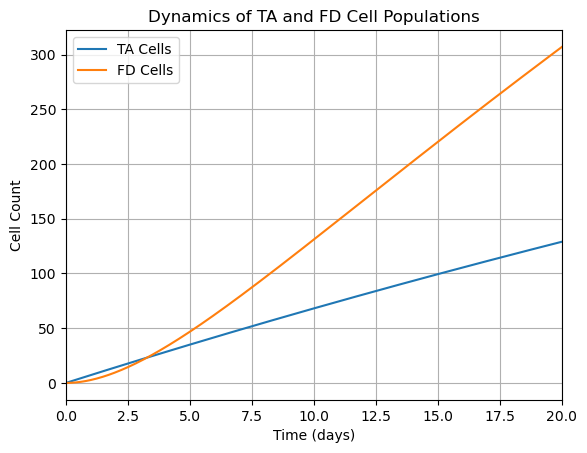

In [94]:
# Baseline ODE simulation

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Convert all rates to per hour
N0 = 18 # constant stem cell number
r = 1 / (2.5 * 24) # stem cell division rate (per hour)
lam = 1 / 30 # TA cell division rate (per hour)
d = 0.0338 # TA differentiation rate (per hour)
gamma = 1 / (3.5 * 24) # FD cell apoptosis rate (per hour)

def ode_model(t, y):
    TA, FD = y
    dTA_dt = r * N0 + (lam - d) * TA
    dFD_dt = d * TA - gamma * FD
    return [dTA_dt, dFD_dt]

y0 = [0, 0]

t_span = (0, 480)
t_eval = np.linspace(t_span[0], t_span[1], 500)
sol = solve_ivp(ode_model, t_span, y0, t_eval=t_eval)

plt.figure()
plt.plot(sol.t / 24, sol.y[0], label='TA Cells')
plt.plot(sol.t / 24, sol.y[1], label='FD Cells')
plt.xlim(0, 20)
plt.xlabel('Time (days)')
plt.ylabel('Cell Count')
plt.title('Dynamics of TA and FD Cell Populations')
plt.legend()
plt.grid(True)
plt.show()

Stem cell population (S) is likely held constant.
No cell death is assumed for either TA or FD, or death rates are very low.
The system is in steady exponential growth mode.
FD cells accumulate faster than TA cells, because TA keeps expanding and feeds into FD.

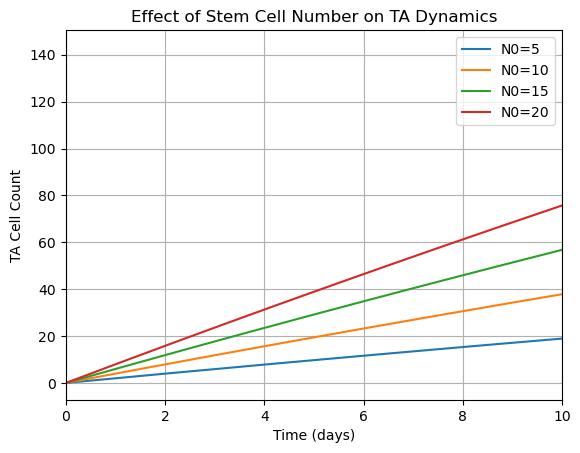

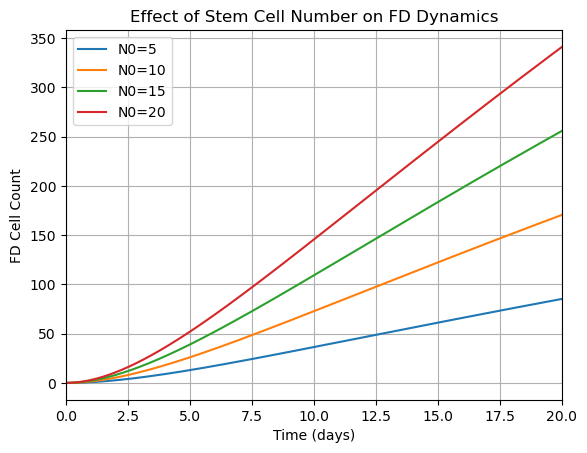

In [96]:
# Numerical experiments varying population sizes
N0_values = [5, 10, 15, 20]

# Plot TA dynamics for each N0
plt.figure()
for N0 in N0_values:
    # Overwrite global N0 directly (no need to restore)
    sol = solve_ivp(ode_model, t_span, y0, t_eval=t_eval)
    plt.plot(sol.t / 24, sol.y[0], label=f'N0={N0}')
plt.xlim(0, 10)
plt.xlabel('Time (days)')
plt.ylabel('TA Cell Count')
plt.title('Effect of Stem Cell Number on TA Dynamics')
plt.legend()
plt.grid(True)
plt.show()

# Plot FD dynamics for each N0
plt.figure()
for N0 in N0_values:
    sol = solve_ivp(ode_model, t_span, y0, t_eval=t_eval)
    plt.plot(sol.t / 24, sol.y[1], label=f'N0={N0}')
plt.xlabel('Time (days)')
plt.ylabel('FD Cell Count')
plt.xlim(0, 20)
plt.title('Effect of Stem Cell Number on FD Dynamics')
plt.legend()
plt.grid(True)
plt.show()

More stem cells = faster production = higher counts

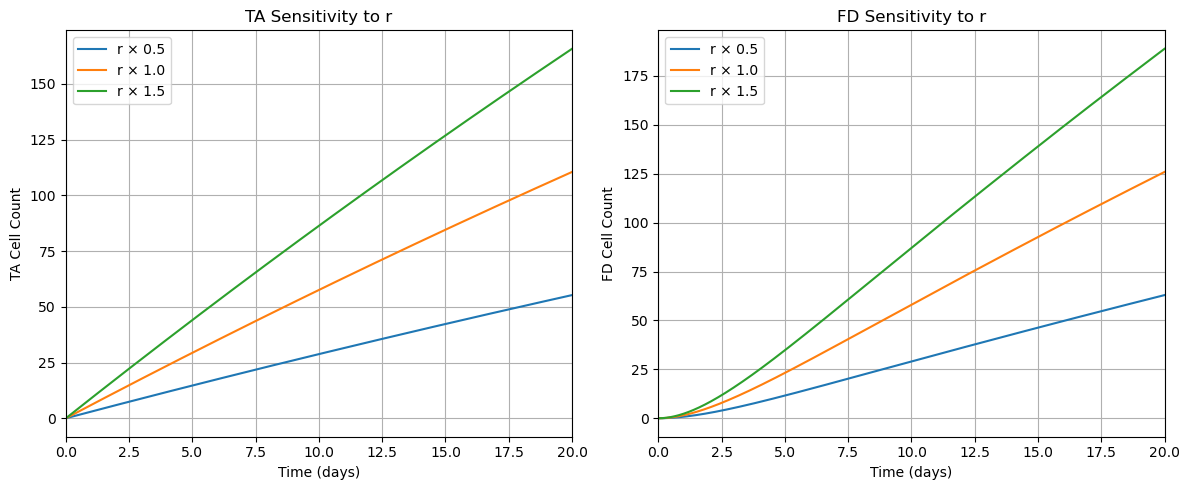

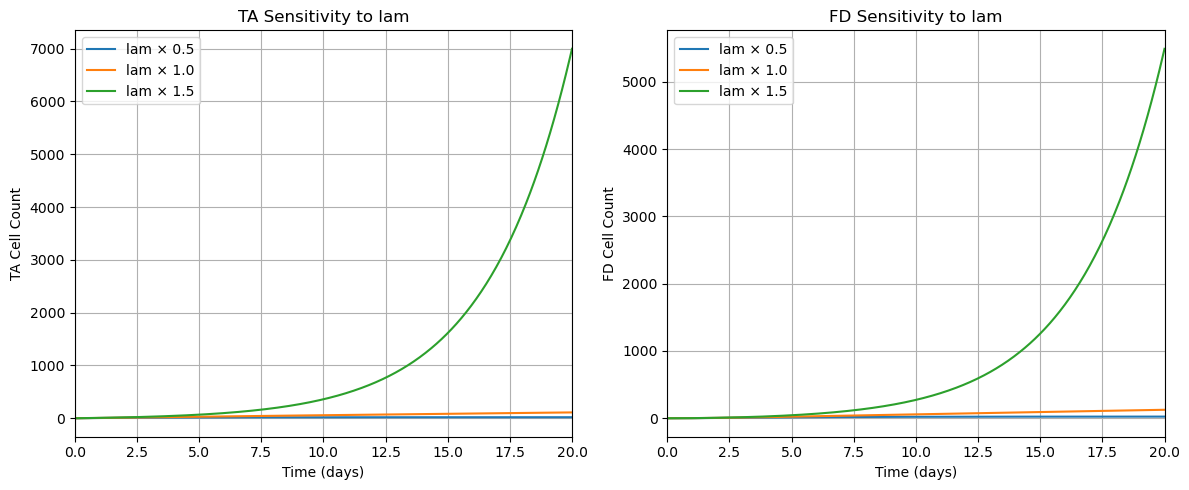

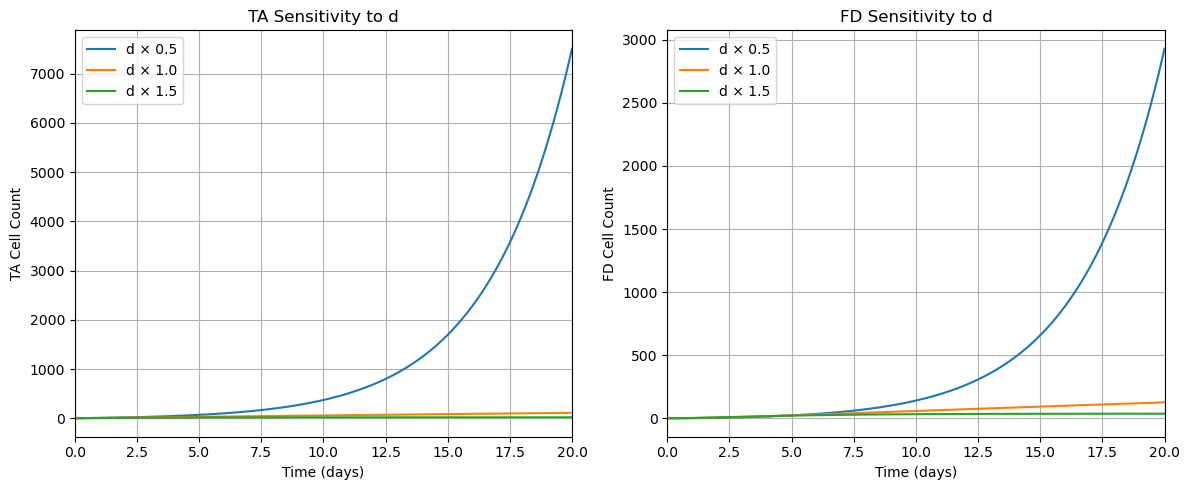

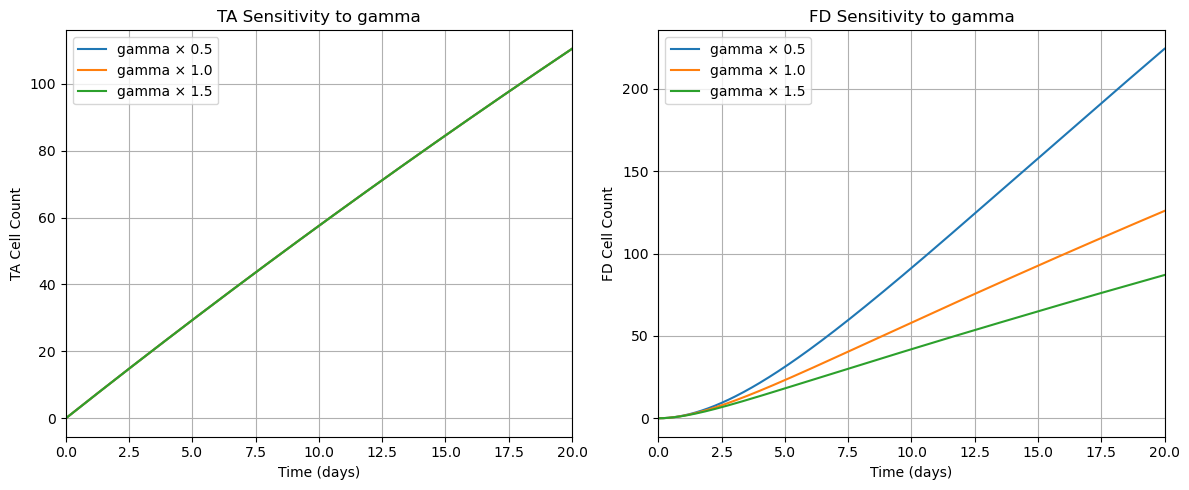

In [104]:
# Parameter sensitivity analysis for TA and FD cells
factors = [0.5, 1.0, 1.5]

param_dict = {
    "r": r,
    "lam": lam,
    "d": d,
    "gamma": gamma
}

param_names = ["r", "lam", "d", "gamma"]

for param in param_names:
    plt.figure(figsize=(12, 5))

    # TA cells
    plt.subplot(1, 2, 1)
    for f in factors:
        # Reset parameters
        r = param_dict["r"]
        lam = param_dict["lam"]
        d = param_dict["d"]
        gamma = param_dict["gamma"]

        # Perturb selected parameter
        if param == "r":
            r *= f
        elif param == "lam":
            lam *= f
        elif param == "d":
            d *= f
        elif param == "gamma":
            gamma *= f

        sol = solve_ivp(ode_model, t_span, y0, t_eval=t_eval)
        plt.plot(sol.t / 24, sol.y[0], label=f"{param} × {f:.1f}")
    
    plt.title(f"TA Sensitivity to {param}")
    plt.xlabel("Time (days)")
    plt.ylabel("TA Cell Count")
    plt.xlim(0, 20)
    plt.grid(True)
    plt.legend()

    # FD cells
    plt.subplot(1, 2, 2)
    for f in factors:
        # Reset parameters again for FD
        r = param_dict["r"]
        lam = param_dict["lam"]
        d = param_dict["d"]
        gamma = param_dict["gamma"]

        if param == "r":
            r *= f
        elif param == "lam":
            lam *= f
        elif param == "d":
            d *= f
        elif param == "gamma":
            gamma *= f

        sol = solve_ivp(ode_model, t_span, y0, t_eval=t_eval)
        plt.plot(sol.t / 24, sol.y[1], label=f"{param} × {f:.1f}")
    
    plt.title(f"FD Sensitivity to {param}")
    plt.xlabel("Time (days)")
    plt.ylabel("FD Cell Count")
    plt.xlim(0, 20)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

The system is very sensitive to changes in lambda, especially when lambda > d. Even small perturbations can lead to huge changes in downstream cell populations.

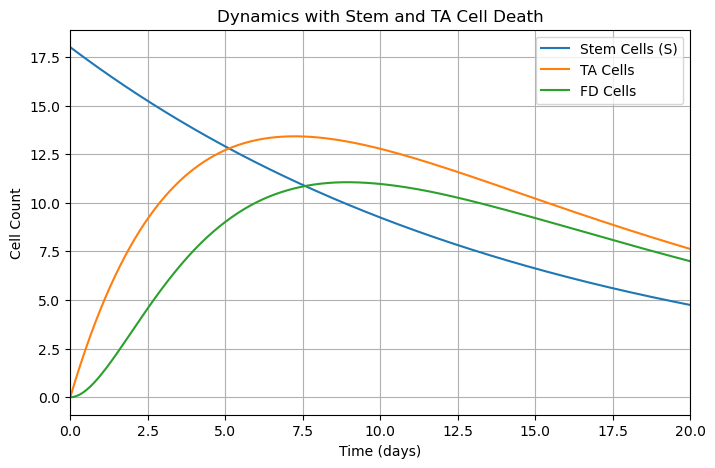

In [114]:
# Model including stem (S) and TA death

# Updated initial conditions
S0 = 18
TA0 = 0
FD0 = 0
y0 = [S0, TA0, FD0]

# Updated parameters (existing + new)
mu_S = 1 / (15 * 24) # stem cell death rate (per hour)
mu_TA = 1 / 100 # TA cell death rate (per hour)

# Updated ODE model with S and TA death
def ode_model_with_death(t, y):
    S, TA, FD = y
    dS_dt = -mu_S * S # stem cells die
    dTA_dt = r * S + (lam - d - mu_TA) * TA # new TA from S, growth/death/diff of TA
    dFD_dt = d * TA - gamma * FD # same FD dynamics

    return [dS_dt, dTA_dt, dFD_dt]

# Simulate over time
sol = solve_ivp(ode_model_with_death, t_span, y0, t_eval=t_eval)

# Plot all 3 populations
plt.figure(figsize=(8, 5))
plt.plot(sol.t / 24, sol.y[0], label='Stem Cells (S)')
plt.plot(sol.t / 24, sol.y[1], label='TA Cells')
plt.plot(sol.t / 24, sol.y[2], label='FD Cells')
plt.xlabel("Time (days)")
plt.ylabel("Cell Count")
plt.title("Dynamics with Stem and TA Cell Death")
plt.legend()
plt.xlim(0, 20)
plt.grid(True)
plt.xlim(0, t_span[1] / 24)
plt.show()

Stem cells steadily decline	due to death and no self-renewal.
TA peaks early then decays because stem cell input shrinks, and TA cells die.
FD peaks later then decays follows TA pattern, lagged because it accumulates TA-derived cells.

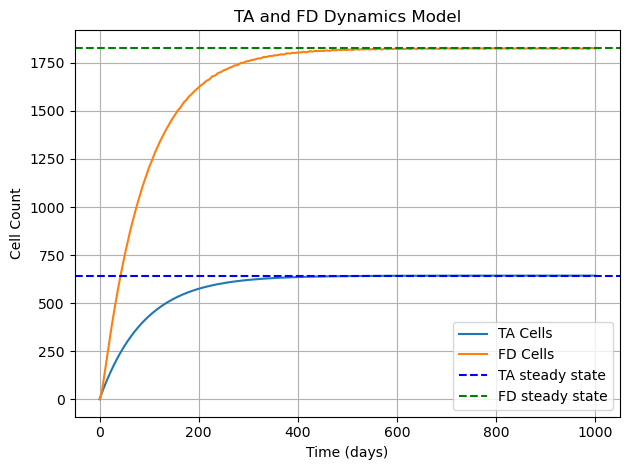

In [6]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters (in per hour)
r = 1 / (2.5 * 24)         # stem cell division rate
N0 = 18                    # constant stem cell number
lam = 1 / 30               # TA division rate
d = 0.0338                 # TA differentiation rate
gamma = 1 / (3.5 * 24)     # FD apoptosis rate

# Time setup
t_span = (0, 24000)  # simulate for 100 days (in hours)
t_eval = np.linspace(*t_span, 1000)

# ODE system
def model(t, y):
    TA, FD = y
    dTA_dt = r * N0 + (lam - d) * TA
    dFD_dt = d * TA - gamma * FD
    return [dTA_dt, dFD_dt]

# Initial conditions
y0 = [0, 0]

# Solve the system
sol = solve_ivp(model, t_span, y0, t_eval=t_eval)

# Steady states
TA_star = (r * N0) / (d - lam)
FD_star = (d / gamma) * TA_star

# Plotting
plt.figure()
plt.plot(sol.t / 24, sol.y[0], label='TA Cells')
plt.plot(sol.t / 24, sol.y[1], label='FD Cells')
plt.axhline(TA_star, color='blue', linestyle='--', label='TA steady state')
plt.axhline(FD_star, color='green', linestyle='--', label='FD steady state')
plt.xlabel('Time (days)')
plt.ylabel('Cell Count')
plt.title('TA and FD Dynamics Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Blue solid line – TA Cells:
Generated from stem cells, Self-replicate at rate λ, Differentiate into FD cells at rate d

Orange solid line – FD Cells:
Produced from TA cells at rate d, Die at rate γ

Blue dashed line – TA steady state:
theoretical long-term value of the TA cell population, only defined and positive when d>λ

Green dashed line – FD steady state:
This is the steady state of FD cells, based on TA

Increase d:
TA steady state decreases (more TA cells lost)
FD production rate increases (faster TA -> FD flow)
FD steady state can increase

If λ<d, then both eigenvalues negative -> stable node
If λ>d, then unstable -> unbounded growth

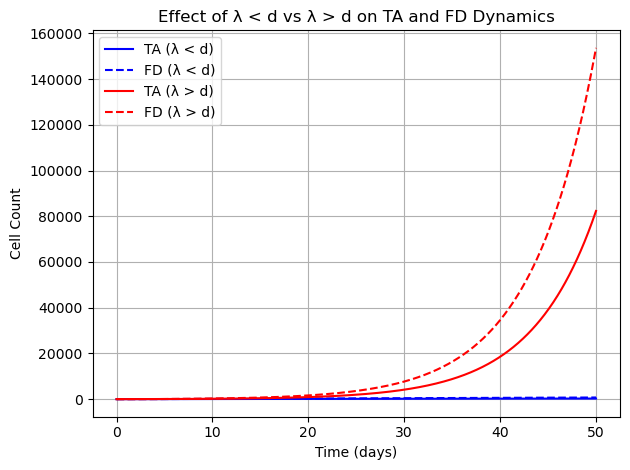

In [146]:
# Define two lambda values for comparison
lambda_stable = 0.0333  # lambda < d: stable
lambda_unstable = 0.04  # lambda > d: unstable

# Reuse other parameters
r = 1 / (2.5 * 24)
N0 = 18
d = 0.0338
gamma = 1 / (3.5 * 24)

# Time span for 50 days
t_span = (0, 24 * 50)
t_eval = np.linspace(*t_span, 1000)

# Initial condition
y0 = [0, 0]

# Function to simulate the model
def simulate_lambda(lam_val):
    def model(t, y):
        TA, FD = y
        dTA_dt = r * N0 + (lam_val - d) * TA
        dFD_dt = d * TA - gamma * FD
        return [dTA_dt, dFD_dt]
    return solve_ivp(model, t_span, y0, t_eval=t_eval)

# Run simulations
sol_stable = simulate_lambda(lambda_stable)
sol_unstable = simulate_lambda(lambda_unstable)

# Plot
plt.figure()

# Stable case
plt.plot(sol_stable.t / 24, sol_stable.y[0], label='TA (λ < d)', color='blue')
plt.plot(sol_stable.t / 24, sol_stable.y[1], label='FD (λ < d)', color='blue', linestyle='--')

# Unstable case
plt.plot(sol_unstable.t / 24, sol_unstable.y[0], label='TA (λ > d)', color='red')
plt.plot(sol_unstable.t / 24, sol_unstable.y[1], label='FD (λ > d)', color='red', linestyle='--')

plt.xlabel("Time (days)")
plt.ylabel("Cell Count")
plt.title("Effect of λ < d vs λ > d on TA and FD Dynamics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

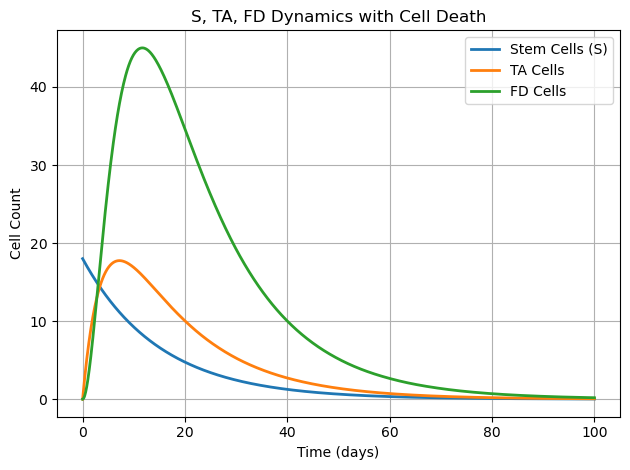

In [142]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters (per hour)
r = 1 / (2.5 * 24)       # stem cell division rate
lam = 1 / 30             # TA division rate
d = 0.0338               # TA differentiation rate
gamma = 1 / (3.5 * 24)   # FD death rate
mu_S = 1 / (15 * 24)     # stem cell death rate
mu_TA = 1 / 100          # TA death rate

# Time span (simulate 100 days)
t_span = (0, 2400)  # in hours
t_eval = np.linspace(*t_span, 1000)

# Initial conditions: [S, TA, FD]
y0 = [18, 0, 0]

# Full ODE model: S, TA, FD with death
def model_full(t, y):
    S, TA, FD = y
    dS_dt = -mu_S * S                            # stem cells die
    dTA_dt = r * S + (lam - d - mu_TA) * TA      # TA input, division, diff, death
    dFD_dt = d * TA - gamma * FD                 # FD input and death
    return [dS_dt, dTA_dt, dFD_dt]

# Simulate
sol = solve_ivp(model_full, t_span, y0, t_eval=t_eval)

# Extract results
S, TA, FD = sol.y

# Plot
plt.figure()
plt.plot(sol.t / 24, S, label='Stem Cells (S)', linewidth=2)
plt.plot(sol.t / 24, TA, label='TA Cells', linewidth=2)
plt.plot(sol.t / 24, FD, label='FD Cells', linewidth=2)
plt.xlabel("Time (days)")
plt.ylabel("Cell Count")
plt.title("S, TA, FD Dynamics with Cell Death")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
